In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml


In [2]:
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_rollout"
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/archive_skebs/skebs_conv_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_12_24h/forecast"
mode_ensemble = False
rmse_magnitudes = xr.open_dataset("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast/magnitudes_fhmean_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc")

In [3]:
with open("/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

sampler = XRSamplerByYear("/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained/model.yml")

def get_data(rollout_files):
    # get pred and true data
    pred_da_list = []
    true_da_list = []
    for file in rollout_files:
        ds = xr.open_dataset(file)
        pred_da_list.append(ds)
        
        da_true = sampler(ds.time.values[0])
        true_da_list.append(da_true)
    
    da_pred = xr.concat(pred_da_list, dim='time')
    da_true = xr.concat(true_da_list, dim='time')
    da_true = da_true.assign_coords(level=da_pred.level)
    return da_true, da_pred

## define metrics

### spread-error



In [4]:
def open_and_concat(files):
    ds_list = [xr.open_dataset(file) for file in files]
    return xr.concat(ds_list, dim='time')

In [5]:
def error_spread(eval_fh):
    std_files = glob(join(rollout_dir, f"ens_std_2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"ens_std_2013*/*{eval_fh:03}.nc"))
    err_files = glob(join(rollout_dir, f"ens_rmse_2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"ens_rmse_2013*/*{eval_fh:03}.nc"))
    std_files.sort()
    err_files.sort()

    std, err = open_and_concat(std_files), open_and_concat(err_files)
    std = std.mean(dim="time") #time lat lon level
    err = err.mean(dim="time")

    return err, std


# run metrics

In [6]:
import multiprocessing
from functools import partial

In [7]:
# f = partial(rmse, )
forecast_hours = list(range(24, 121, 24))
# forecast_hours = list(range(6, 13, 6))
with multiprocessing.Pool(12) as p:
    result = p.map(error_spread, forecast_hours)


In [8]:
results = {fh: {'error': res[0], "spread": res[1]} for fh, res in zip(forecast_hours, result)}

# make visuals

In [9]:
# # RMSE
# mean_ds = []
# for res in result:
#     zonal_mean = res[0][["U", "V", "T", "Qtot"]].mean(dim=["longitude"])
#     mean_ds.append(zonal_mean)

# mean_lon = xr.concat(mean_ds, dim=pd.Index(forecast_hours, name='fh'))
# mean = mean_lon.mean(dim="fh")



In [10]:
# std
std_ds = {}
for fh, res in results.items():
    zonal_mean = res["spread"][["U", "V", "T", "Qtot"]].mean(dim=["longitude"])
    std_ds[fh] = zonal_mean



In [11]:
def plot(std_ds, fh, variable):
    std = std_ds[fh]

    berner_levels = np.concatenate([np.linspace(0, 10, 14), 
                                np.linspace(10, 20, 7),
                               np.linspace(20, 30, 3),
                               np.linspace(30, 40, 8)], axis=0)

    std_berner = std.assign_coords(level=berner_levels)
    std_berner[variable].plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)
    plt.title(f"{fh}h {variable} std")
    plt.show()


In [12]:
def plotUscaled(std_ds, fh, variable):
    std = std_ds[fh]

    berner_levels = np.concatenate([np.linspace(0, 10, 14), 
                                np.linspace(10, 20, 7),
                               np.linspace(20, 30, 3),
                               np.linspace(30, 40, 8)], axis=0)
    std = std * rmse_magnitudes[variable] / rmse_magnitudes[variable].sum()

    std_berner = std.assign_coords(level=berner_levels)
    std_berner[variable].plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)
    plt.title(f"{fh}h {variable} std")
    plt.show()

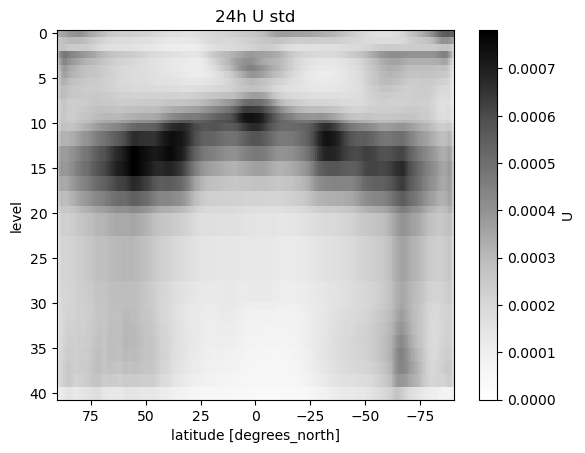

In [13]:
plotUscaled(std_ds, 24, "U")


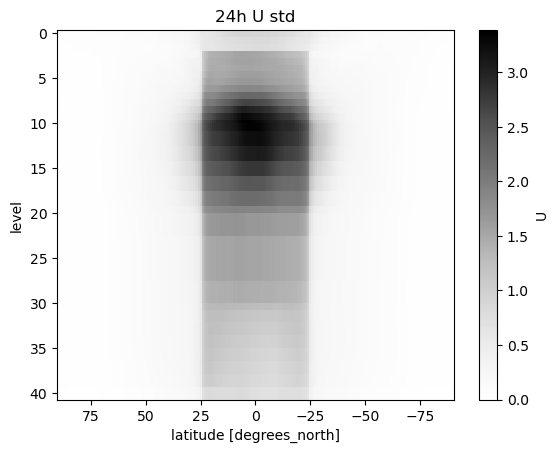

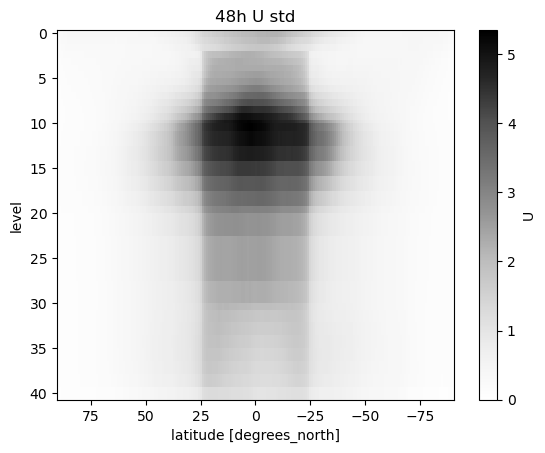

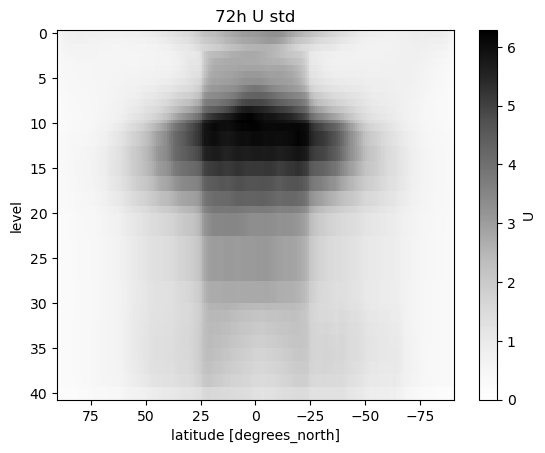

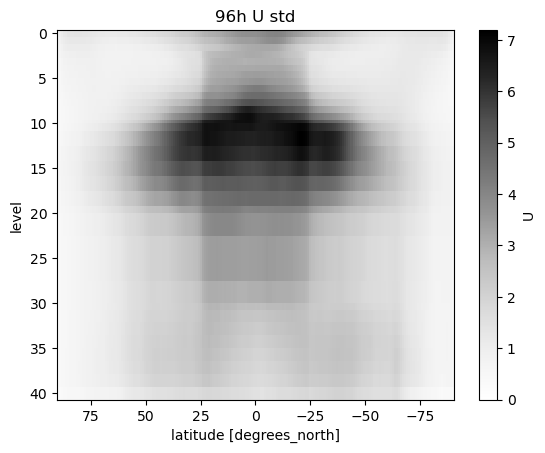

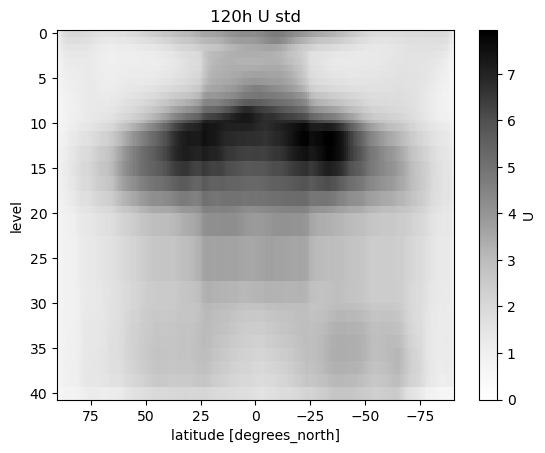

In [37]:
plot(std_ds, 24, "U")
plot(std_ds, 48, "U")
plot(std_ds, 72, "U")
plot(std_ds, 96, "U")

plot(std_ds, 120, "U")

mean["Qtot"].plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

## save files

In [28]:
save_path = join(rollout_dir, "spread_error_maps")
os.makedirs(save_path, exist_ok=True)
for fh, res in zip(forecast_hours, result):
    res[0].to_netcdf(join(save_path, f"rmse_{fh:03}.nc"))
    res[1].to_netcdf(join(save_path, f"std_{fh:03}.nc"))
